In [2]:
from tritonclient.utils import *
import tritonclient.grpc as grpcclient
import tritonclient.http as httpclient


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Preflight Check: 

* start the inference server (recall run.sh), our server runs on localhost here.
* tritonserver --model-repository=model_repo

## Check lifeliness of models:

* http://localhost:8000/v2/models/model_head
* http://localhost:8000/v2/models/model_headless

# A request handler for our models

In [3]:
# lets query the model "model_headless"
# input is constant size, not normalized

# What do we do here? We craft a request to query the model which is served. 
# We need servername, modelname, input/outputmapping
def get_model_headless(image):
    model_name = "model_headless"
    
    with httpclient.InferenceServerClient("localhost:8000") as client:
        input_image = image.astype(np.float32)
        
        inputs = [
            httpclient.InferInput("x.1", input_image.shape,
                                np_to_triton_dtype(input_image.dtype)),
        ]
        
        inputs[0].set_data_from_numpy(input_image)
        # a second input would look like
        # inputs[1].set_data_from_numpy(....)
        
        outputs = [
            httpclient.InferRequestedOutput("2085")
        ]

        response = client.infer(model_name, inputs, request_id=str(1), outputs=outputs)
        result = response.get_response()

        feature_vector = response.as_numpy("2085")
        
    return feature_vector
        
# Lets try our routine
img = np.ones(shape=(1,3,768,768))
print("input shape:" , img.shape)

feature_vector = get_model_headless(img)
print("output shape: ", feature_vector.shape)

input shape: (1, 3, 768, 768)
output shape:  (1, 512)


## Another request handler - you already got the gist

In [4]:
def get_model_head(features):
    model_name = "model_head"
    
    with httpclient.InferenceServerClient("localhost:8000") as client:
        features_vec = features.astype(np.float32)
        
        inputs = [
            httpclient.InferInput("features", features_vec.shape,
                                np_to_triton_dtype(features_vec.dtype)),
        ]
        
        inputs[0].set_data_from_numpy(features_vec)
        
        outputs = [
            httpclient.InferRequestedOutput("39"),
            httpclient.InferRequestedOutput("40")
        ]

        response = client.infer(model_name, inputs, request_id=str(1), outputs=outputs)
        result = response.get_response()

        pred39_ = response.as_numpy("39") # likelihood
        pred40_ = response.as_numpy("40") # class label 81000+ classes
        
    return pred39_, pred40_
        
# Lets try our routine
features = np.ones(shape=(1,512))
print("input shape:" , features.shape)

pred = get_model_head(features)
print(pred)

input shape: (1, 512)
(array([[1.8529143e-05]], dtype=float32), array([[26606]], dtype=int32))


## What was achieved so far?

The two models work! 

Now: Lets go back to the Triton server and glue both together! We perform one request, both models are used in sequence on Triton server and class comes back.

Lets create a so called "ensemble" model in Triton - we will call it "both_together"

In [5]:
# we call our model again

def get_both_together(image):
    model_name = "both_together"
    
    with httpclient.InferenceServerClient("localhost:8000") as client:
        input_image = image.astype(np.float32)
        
        inputs = [
            httpclient.InferInput("image", input_image.shape,
                                np_to_triton_dtype(input_image.dtype)),
        ]
        
        inputs[0].set_data_from_numpy(input_image)
        
        outputs = [
            httpclient.InferRequestedOutput("conf"),
            httpclient.InferRequestedOutput("label")
        ]

        response = client.infer(model_name, inputs, request_id=str(1), outputs=outputs)
        result = response.get_response()

        conf_ = response.as_numpy("conf") # likelihood
        label_ = response.as_numpy("label") # class label 81000+ classes
        
    return conf_, label_
        
# Lets try our routine

img = np.ones(shape=(1,3,768,768))
print("input shape:" , img.shape)

pred = get_both_together(img)
print(pred)

input shape: (1, 3, 768, 768)
(array([[1.5119517e-05]], dtype=float32), array([[50843]], dtype=int32))


Whats Missing?

Normalization - lets put this in front of our model together with 

In [7]:
def get_dali_decompress(data):
    ## check input/output definition of this model here: http://localhost:8000/v2/models/dali
    model_name = "dali"
    
    with httpclient.InferenceServerClient("localhost:8000") as client:
        input0_data = data.astype(np.uint8)

        inputs = [
            httpclient.InferInput("jpeg", input0_data.shape,
                                np_to_triton_dtype(input0_data.dtype))
        ]
        
        inputs[0].set_data_from_numpy(input0_data)
 
        outputs = [
            httpclient.InferRequestedOutput("image"),
        ]

        response = client.infer(model_name, inputs, request_id=str(1), outputs=outputs)
        result = response.get_response()

        image_tensor = response.as_numpy("image")

    return image_tensor

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2.6399999


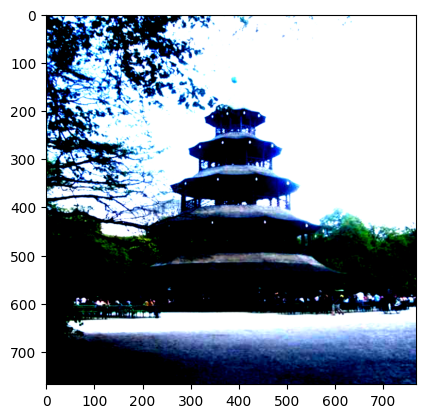

In [8]:

with open('imgs/003adbc21d2b9e75.jpg') as fin:
    jpeg_bytes = np.fromfile(fin, dtype = np.uint8)
    jpeg_bytes = np.expand_dims(jpeg_bytes, axis=0)
    
    image = get_dali_decompress(jpeg_bytes)
    image = np.transpose(image[0], [1,2,0])
    print(np.max(image))
    
    plt.imshow(image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


445    Kopaonik
Name: name, dtype: object


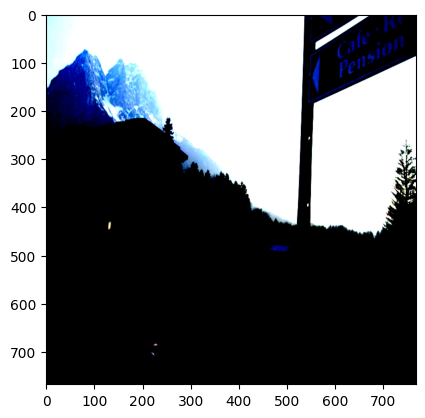

In [9]:

def inference_this_file(fname):
    id_2_name = pd.read_csv("imgs/class2name.csv")
    
    with open(fname) as fin:
        jpeg_bytes = np.fromfile(fin, dtype = np.uint8)
        jpeg_bytes = np.expand_dims(jpeg_bytes, axis=0)

        image = get_dali_decompress(jpeg_bytes)
        
        tposed_image = np.transpose(image[0], [1,2,0])
        plt.imshow(tposed_image)

        conf, label = get_both_together(image)
                
        print(id_2_name.loc[id_2_name['class_id'] == label[0][0]].name)
        
inference_this_file("imgs/023145233aeabdc0.jpg")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


70170    Chinesischer_Turm
Name: name, dtype: object
70170    Chinesischer_Turm
Name: name, dtype: object
19170    Eiffel_Tower
Name: name, dtype: object


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


19170    Eiffel_Tower
Name: name, dtype: object
70170    Chinesischer_Turm
Name: name, dtype: object


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


70170    Chinesischer_Turm
Name: name, dtype: object
445    Kopaonik
Name: name, dtype: object
68480    Kenozyorsky_National_Park
Name: name, dtype: object


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


70170    Chinesischer_Turm
Name: name, dtype: object
36516    Naturpark_Hohes_Venn_(Nordeifel)
Name: name, dtype: object


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


19170    Eiffel_Tower
Name: name, dtype: object
19602    Cordillera_del_Paine
Name: name, dtype: object
70431    Parque_Estadual_Terra_Ronca
Name: name, dtype: object


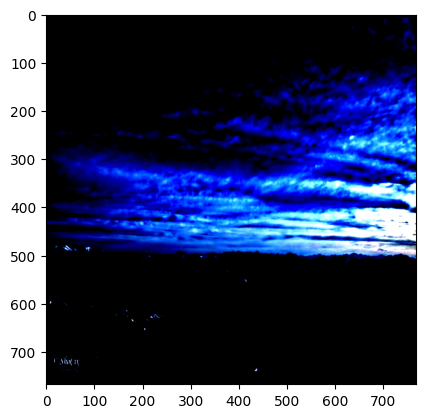

In [8]:
import os

directory = 'imgs'
for filename in os.listdir(directory):
    if filename.endswith('.jpg'):
        
        inference_this_file(directory + "/" + filename)
        

In [9]:
import time

start = time.time()

for i in range(1000):
    #get_kaggle_fp16(img)
    i

duration = time.time()-start
print(duration, 1000./duration)

8.726119995117188e-05 11459846.994535519
